In this script, we calclate global distribution of dust DRE by using the DREE-integration method introduced in Song et al. 2022 section 4 Eq.(6).

(1), DREE_k can be directly obtained from our size-resolved DREE dataset developed in this study. Our size-resolved DREE dataset is for 6 dust models. 

References:

Song, Q., Zhang, Z., Yu, H., Ginoux, P., and Shen, J.: Global dust optical depth climatology derived from CALIOP and MODIS aerosol retrievals on decadal timescales: regional and interannual variability, Atmos. Chem. Phys., 21, 13369–13395, https://doi.org/10.5194/acp-21-13369-2021, 2021.



In [1]:
# ----------
# Colab does not have basemap package
# This cell is to manually install basemap package to google colab
# Note, we need to 'Restart Runtime' after we install the package.
#----------

!pip install basemap

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from netCDF4 import Dataset
from scipy import stats
from mpl_toolkits.basemap import Basemap  #need to install manually by using '!pip install basemap'
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator

# 1. Load DREE Data Array

In [3]:
#----------
# Read Size-resolved DREE dataset developed in this study.
# We developed size-resolved DREE for six dust models (see Table 1 in the paper Song et al. 2022) in SW and LW respectively.
# Here we only calculate MeanSWRI-Sphere dust model as an example. In fact, dust DRE can be calculated for 6 dust models listed in Table 1
#----------

from funct_call import load_DREE_data
dreesw_meanri_sphere_data = load_DREE_data()
print(dreesw_meanri_sphere_data)

dreesw_meanri_sphere_toa = np.array(dreesw_meanri_sphere_data.variables['DREE_TOA'][:])
#DREE_TOA(sizebin_center, month, lat, lon)
dreesw_meanri_sphere_bin_edge = np.array(dreesw_meanri_sphere_data.variables['sizebin_edge'])
dreesw_meanri_sphere_bin_center = np.array(dreesw_meanri_sphere_data.variables['sizebin_center'])
dreesw_meanri_sphere_suf = np.array(dreesw_meanri_sphere_data.variables['DREE_SUF'][:])

lat = dreesw_meanri_sphere_data.variables['lat']
#print(lat)
lon = dreesw_meanri_sphere_data.variables['lon']
#print(lon)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): sizebin_edge(11), sizebin_center(10), month(12), lat(90), lon(72)
    variables(dimensions): float32 sizebin_edge(sizebin_edge), float32 sizebin_center(sizebin_center), float32 month(month), float32 lat(lat), float32 lon(lon), float32 DREE_TOA(sizebin_center, month, lat, lon), float32 DREE_SUF(sizebin_center, month, lat, lon), float32 DREE_TOA_std(sizebin_center, month, lat, lon), float32 DREE_SUF_std(sizebin_center, month, lat, lon)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): sizebin_edge(11), sizebin_center(10), month(12), lat(90), lon(72)
    variables(dimensions): float32 sizebin_edge(sizebin_edge), float32 sizebin_center(sizebin_center), float32 month(month), float32 lat(lat), float32 lon(lon), float32 DREE_TOA(sizebin_center, month, lat, lon), float32 DREE_SUF(sizebin_center, month, lat, lon), fl

Song et al. DREE lat and lon

In [4]:
print(lat[:]) #Song et al. DREE range of lat and lon
print(lon[:])
print(len(lat[:]))
print(len(lon[:]))

[-89. -87. -85. -83. -81. -79. -77. -75. -73. -71. -69. -67. -65. -63.
 -61. -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39. -37. -35.
 -33. -31. -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.
  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.
  23.  25.  27.  29.  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.
  51.  53.  55.  57.  59.  61.  63.  65.  67.  69.  71.  73.  75.  77.
  79.  81.  83.  85.  87.  89.]
[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162.5  167.5
  172.5  177.5]
90
72


In [5]:
print(dreesw_meanri_sphere_bin_center)
dreesw_meanri_sphere_toa = np.array(dreesw_meanri_sphere_data.variables['DREE_TOA'][:])
#dreesw_meanri_sphere_toa(sizebin_center, month, lat, lon)

[ 0.14976312  0.2988167   0.5962177   1.1896107   2.3735855   4.7359257
  9.449414   18.85406    37.618793   75.059364  ]


# 2. Download DustCOMM Data

Read in DustCOMM dataset for Mean DAOD, lat, lon, and sources data

In [6]:
#9/29 
#----------
#using DustCOMM 2021 papers b) https://dustcomm.atmos.ucla.edu/
# specifically https://dustcomm.atmos.ucla.edu/data/K21b/ dataset DustCOMM_source_region_DAOD_seas_bin_abs.nc
#----------

from funct_call import load_DustCOMM_data
daod_Dustcomm_PM20_Dataset = load_DustCOMM_data()
print(daod_Dustcomm_PM20_Dataset) #[season,source,diameter,lat,lon,bin]

lat_Dustcomm_PM20 = np.array(daod_Dustcomm_PM20_Dataset.variables['lat'][:])
lon_Dustcomm_PM20 = np.array(daod_Dustcomm_PM20_Dataset.variables['lon'][:])
mean_Daod_Dustcomm_20PM = np.array(daod_Dustcomm_PM20_Dataset.variables['Mean'][:])
dustcomm_seas = np.array(daod_Dustcomm_PM20_Dataset.variables['season'][:])
dustcomm_Sources_PM20 = np.array(daod_Dustcomm_PM20_Dataset.variables['source'][:]) 
dustcomm_bin_lower = np.array(daod_Dustcomm_PM20_Dataset.variables['bin_D_lower'][:])
dustcomm_bin_upper = np.array(daod_Dustcomm_PM20_Dataset.variables['bin_D_upper'][:])
print(dustcomm_bin_lower)
print(dustcomm_bin_upper)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): season(4), source(9), diameter(6), lat(96), lon(144), bin(6)
    variables(dimensions): float64 season(season), float64 source(source), float64 bin_D_lower(diameter), float64 bin_D_upper(diameter), float64 lat(lat), float64 lon(lon), float64 Median(lat, lon, bin, source, season), float64 Mean(lat, lon, bin, source, season), float64 Neg1sigma(lat, lon, bin, source, season), float64 Pos1sigman(lat, lon, bin, source, season), float64 Neg2sigma(lat, lon, bin, source, season), float64 Pos2sigma(lat, lon, bin, source, season)
    groups: 
[ 0.2  0.5  1.   2.5  5.  10. ]
[ 0.5  1.   2.5  5.  10.  20. ]


In [7]:
print(dustcomm_seas) 
#1:DJF, 2:MAM, 3:JJA, 4:SON

[1. 2. 3. 4.]


In [8]:
bins = daod_Dustcomm_PM20_Dataset.dimensions['bin']
print(bins)

<class 'netCDF4._netCDF4.Dimension'>: name = 'bin', size = 6


In [9]:
print(mean_Daod_Dustcomm_20PM.shape) #(96 lat, 144 lon, 6 bins, 9 sources,4 seasons)
#print(mean_Daod_Dustcomm_20PM)

(96, 144, 6, 9, 4)


In [10]:
print(dreesw_meanri_sphere_toa.shape)
dreesw_meanri_sphere_toa[:3].shape

(10, 12, 90, 72)


(3, 12, 90, 72)

# 2/1 Match DREE bins (10) to DAOD bins (6)

## change to weighted sum

In [11]:
#Apply bin weights

# Read the '.txt' file that is uploaded above. 
faod = np.loadtxt('../Data/Faod_kok17PSD_2Shape_3RI.txt',skiprows=1)
faod_meanri_sphere = faod[:,1]
print(faod_meanri_sphere)

[6.248e-05 6.433e-03 1.043e-01 2.098e-01 3.314e-01 2.427e-01 9.430e-02
 1.090e-02 5.232e-05 1.585e-13]


In [12]:
weights = np.array(faod_meanri_sphere)
print(np.sum(faod_meanri_sphere))
#weights = np.array(1/faod_meanri_sphere[:3])
print(weights)
print(np.sum(weights))

0.9999478000001585
[6.248e-05 6.433e-03 1.043e-01 2.098e-01 3.314e-01 2.427e-01 9.430e-02
 1.090e-02 5.232e-05 1.585e-13]
0.9999478000001585


In [13]:
#Apply bin weights

# Read the '.txt' file that is uploaded above. 
faod = np.loadtxt('../Data/Faod_kok17PSD_2Shape_3RI.txt',skiprows=1)
faod_meanri_sphere = faod[:,1]
print(faod_meanri_sphere)

faod_mean_sphere_6bins = np.zeros(6)
for i in range(8):
    if i <= 2:
        faod_mean_sphere_6bins[0] = np.sum(faod_meanri_sphere[:3]) #combine first 3 bins as new first bin
    else:
        faod_mean_sphere_6bins[i-2] = faod_meanri_sphere[i]
print(faod_mean_sphere_6bins)
print(np.sum(faod_mean_sphere_6bins))

[6.248e-05 6.433e-03 1.043e-01 2.098e-01 3.314e-01 2.427e-01 9.430e-02
 1.090e-02 5.232e-05 1.585e-13]
[0.11079548 0.2098     0.3314     0.2427     0.0943     0.0109    ]
0.9998954800000001


In [14]:
#mean_Daod_Dustcomm_20PM
dree_Weights = faod_mean_sphere_6bins
print(dreesw_meanri_sphere_toa.shape)
dreesw_meanri_sphere_toa_6bins = np.zeros((6,12,90,72))
for ibin in range(8): #removing last two bin centers bc they are greater than PM20
    for imn in range(12):
        for ilat in range(len(lat)):
            for ilon in range(len(lon)):
                if ibin <= 2:
                    dreesw_meanri_sphere_toa_6bins[0,imn,ilat,ilon] = np.dot(dreesw_meanri_sphere_toa[:3,imn,ilat,ilon],dree_Weights[:3]) #:3 or :2?
                else: #4?
                    dreesw_meanri_sphere_toa_6bins[ibin-2,imn,ilat,ilon] = dreesw_meanri_sphere_toa[ibin,imn,ilat,ilon] #*weights[ibin] #-3?
print(dreesw_meanri_sphere_toa_6bins.shape)

(10, 12, 90, 72)
(6, 12, 90, 72)


 ## Chose North African Sources

In [15]:
north_African_Mean_Daod_20PM = mean_Daod_Dustcomm_20PM[:,:,:,:3,:]
#North Africa = sources #1,2,3 so first 3 (Eastern NorAf, Western North Africa, and South Sahara + Sahel)
print(north_African_Mean_Daod_20PM.shape) #(96lat, 144lon, 6bins, 3sources, 4seasons)
#print(north_African_Mean_Daod_20PM)

(96, 144, 6, 3, 4)


In [16]:
##Look at DustCOMM Data - seasonal resolved,6bins, PM20 
#print(lat_Dustcomm_PM20) 
#print(lon_Dustcomm_PM20)
print(len(lat_Dustcomm_PM20))
print(len(lon_Dustcomm_PM20))

96
144


# 3. Chose Nearest Neighbor of DustCOMM and Song et al. DREE datasets to get same array size and correct corresponding DAOD meausurements for the correct (lat,lon)

Latitude NN (Nearest Neighbor)

In [17]:
#----------
#Choosing nearest neighbor between DustCOMM DAOD coordinates &Song et al. DREE coordinate range
#Song et al. : 90 lattitude values, 72 longitude values
#DustCOMM : 96 lattitude values, 144 longitude values
#--> Song et al. uses every other longitude value that DustCOMM uses
# Latitude is not as simple
#----------

lat_list_dust = list(lat_Dustcomm_PM20)
print(len(lat_list_dust))
nn_lat_song = []
index_dustcomm_lat = []
nn_lat_dustcomm = []

double_index_dustcomm_lat = []
for i in lat_Dustcomm_PM20:
    for j in lat[:]: #Song et al. 2022 DREE
        if np.round(i)+1 == np.round(j) or np.round(i)== np.round(j):
            nn_lat_song.append(j)
            index_dustcomm_lat.append(lat_list_dust.index(i))
            nn_lat_dustcomm.append(i)
print(len(nn_lat_dustcomm))
print(len(index_dustcomm_lat)) #95 instead of 96 indexes


# double -81.0 lat, -45.0 lat, -9.0 lat, +27 lat, +63
#1/9 Jasper said to take the average of latitudes , take the second one 
#[-82.41999816894531, -81.0], [-80.52999877929688, -81.0],
#print(nn_lat_dustcomm.index(-82.41999816894531), nn_lat_dustcomm.index(-80.52999877929688))
#[-46.41999816894531, -45.0], [-44.529998779296875, -45.0],
#print(lat_list_dust.index(-46.41999816894531), lat_list_dust.index(-44.529998779296875))
#print(nn_lat_dustcomm.index(-46.41999816894531), nn_lat_dustcomm.index(-44.529998779296875))
#[-10.420000076293945, -9.0], [-8.526000022888184, -9.0],
#print(nn_lat_dustcomm.index(-10.420000076293945), nn_lat_dustcomm.index(-8.526000022888184))
#[25.579999923706055, 27.0], [27.469999313354492, 27.0],
#print(nn_lat_dustcomm.index(25.579999923706055), nn_lat_dustcomm.index(27.469999313354492))
#[61.58000183105469, 63.0], [63.470001220703125, 63.0],
#print(nn_lat_dustcomm.index(61.58000183105469), nn_lat_dustcomm.index(63.470001220703125))

del nn_lat_dustcomm[80]
del nn_lat_dustcomm[61]
del nn_lat_dustcomm[42]
del nn_lat_dustcomm[23]
del nn_lat_dustcomm[4]
print(len(nn_lat_dustcomm)) 
#print(nn_lat_dustcomm)

#print(index_dustcomm_lat.index(80))
#print(index_dustcomm_lat.index(61))
#print(index_dustcomm_lat.index(42))
#print(index_dustcomm_lat.index(23))
#print(index_dustcomm_lat.index(4))

del index_dustcomm_lat[80]
del index_dustcomm_lat[61]
del index_dustcomm_lat[42]
del index_dustcomm_lat[23]
del index_dustcomm_lat[4]

#print(len(index_dustcomm_lat)) #90
nn_lat = np.sort(list(set(nn_lat_song)))
print(len(nn_lat_song),nn_lat_song)

96
95
95
90
95 [-89.0, -87.0, -85.0, -83.0, -81.0, -81.0, -79.0, -77.0, -75.0, -73.0, -71.0, -69.0, -67.0, -65.0, -63.0, -61.0, -59.0, -57.0, -55.0, -53.0, -51.0, -49.0, -47.0, -45.0, -45.0, -43.0, -41.0, -39.0, -37.0, -35.0, -33.0, -31.0, -29.0, -27.0, -25.0, -23.0, -21.0, -19.0, -17.0, -15.0, -13.0, -11.0, -9.0, -9.0, -7.0, -5.0, -3.0, -1.0, 1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0]


Nearest Neighbor Longitudes

In [18]:
#72 is correct, every other dustcomm lon is chosen
nn_lon = []
index_dustcomm_lon = []
lon_list_dust = list(lon_Dustcomm_PM20)
for i in lon_Dustcomm_PM20 : #dustComm 
    for j in lon[:]: #Song et al
        if np.round(i)== np.round(j):
            nn_lon.append(j)
            index_dustcomm_lon.append(lon_list_dust.index(i))
            
print(len(nn_lon),nn_lon)

72 [-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5, -142.5, -137.5, -132.5, -127.5, -122.5, -117.5, -112.5, -107.5, -102.5, -97.5, -92.5, -87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5, -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5, -7.5, -2.5, 2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5, 92.5, 97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5, 137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5]


Printing to make sure index arrays are the correct size

In [19]:
print(len(index_dustcomm_lat))
print(index_dustcomm_lat)
print(len(index_dustcomm_lon))
print(index_dustcomm_lon)

90
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
72
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142]


# 4. Now match DAOD dataset to match nearest neighbor lattitude and longitude 

In [20]:
#summed DoAD 20PM across 3 sahara sources for 1 north african value
#north_African_Mean_Daod_20PM.shape #(96lat, 144lon, 6bins, 3sources, 4seasons)

print(north_African_Mean_Daod_20PM.shape)#(96, 144, 3) (lat,lon,sources)
#print(len(north_African_Mean_Daod_20PM[:,:,1])) #96 DAoD
sum_North_African_Mean_Daod_20PM = (north_African_Mean_Daod_20PM[:,:,:,0,:] +north_African_Mean_Daod_20PM[:,:,:,1,:] +north_African_Mean_Daod_20PM[:,:,:,2,:]) #/3
print(len(sum_North_African_Mean_Daod_20PM))
print(len(sum_North_African_Mean_Daod_20PM[0]))
print(sum_North_African_Mean_Daod_20PM.shape)
#96 rows of arrays 144 inputs long (one for each latitude)
sum_North_African_lat_lon_DAOD = []

nn_Daod_NAf = []
for i in index_dustcomm_lat:
        nn_Daod_NAf.append(sum_North_African_Mean_Daod_20PM[i][::2]) #72 instead of 144 lon
nn_Daod_NAf = np.array(nn_Daod_NAf)
print(nn_Daod_NAf.shape) # 90 arrays, each array 72 inputs 
   

(96, 144, 6, 3, 4)
96
144
(96, 144, 6, 4)
(90, 72, 6, 4)


# 5. Load F_AOD as bin weights

# 2/1 *** change weights because bins are different lengths and distribution*** add first 3 bins, remove last 2

In [21]:
#Apply bin weights

# Read the '.txt' file that is uploaded above. 
faod = np.loadtxt('../Data/Faod_kok17PSD_2Shape_3RI.txt',skiprows=1)
faod_meanri_sphere = faod[:,1]
print(faod_meanri_sphere)

faod_mean_sphere_6bins = np.zeros(6)
for i in range(8):
    if i <= 2:
        faod_mean_sphere_6bins[0] = np.sum(faod_meanri_sphere[:3]) #combine first 3 bins as new first bin
    else:
        faod_mean_sphere_6bins[i-2] = faod_meanri_sphere[i]
print(faod_mean_sphere_6bins)
print(np.sum(faod_mean_sphere_6bins))

[6.248e-05 6.433e-03 1.043e-01 2.098e-01 3.314e-01 2.427e-01 9.430e-02
 1.090e-02 5.232e-05 1.585e-13]
[0.11079548 0.2098     0.3314     0.2427     0.0943     0.0109    ]
0.9998954800000001


# 6. Calculate SW DRE with DREE, DAOD, and faod

In [22]:
#Apply area weights
from funct_call import deg2rad
#----------
# Calculate dust DRE with DREE-integration method introduced in Song et al. 2022 Eq.(6)
# Dust DRE Dimension: (12 month, 90 latitude, 72 longitude). Unit: (W/m^2)
#----------

nn_dresw_meanri_sphere_toa_bin_weighted = np.zeros((6,12,90,72)) # DREE_SW at TOA for MeanRI-Spheroid dust model 
bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted = np.zeros((12,90,72)) # DREE_LW at TOA for MeanRI-Spheroid dust model

#print(dustcomm_seas) 
#1:DJF, 2:MAM, 3:JJA, 4:SON

#DRE[bin,month,lat,lon] = DREE[bin,month,lat,lon] * DAOD[lat,lon] *F_AOD[bin]

for imn in range(12): #imn for each month
        for ilat in range(90):
            for ilon in range(72):
                if imn == 0 or 1 or 11:
                    nn_dresw_meanri_sphere_toa_bin_weighted[:,imn,ilat,ilon] = dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,0]
                    bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,ilat,ilon] = np.sum(dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,0])
                if imn == 2 or 3 or 4:
                    nn_dresw_meanri_sphere_toa_bin_weighted[:,imn,ilat,ilon] = dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,1]
                    bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,ilat,ilon] = np.sum(dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,1])
                if imn == 5 or 6 or 7:
                    nn_dresw_meanri_sphere_toa_bin_weighted[:,imn,ilat,ilon] = dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,2]
                    bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,ilat,ilon] = np.sum(dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,2])
                if imn == 8 or 9 or 10:
                    nn_dresw_meanri_sphere_toa_bin_weighted[:,imn,ilat,ilon] = dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,3]
                    bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,ilat,ilon] = np.sum(dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,3])
        

# Song et al DREsw_meanri_sphere_toa[imn,ilat,ilon]

In [23]:
print(np.shape(nn_dresw_meanri_sphere_toa_bin_weighted))
print(np.shape(bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted))

(6, 12, 90, 72)
(12, 90, 72)


# 7. DRE Plots by bin for month of July

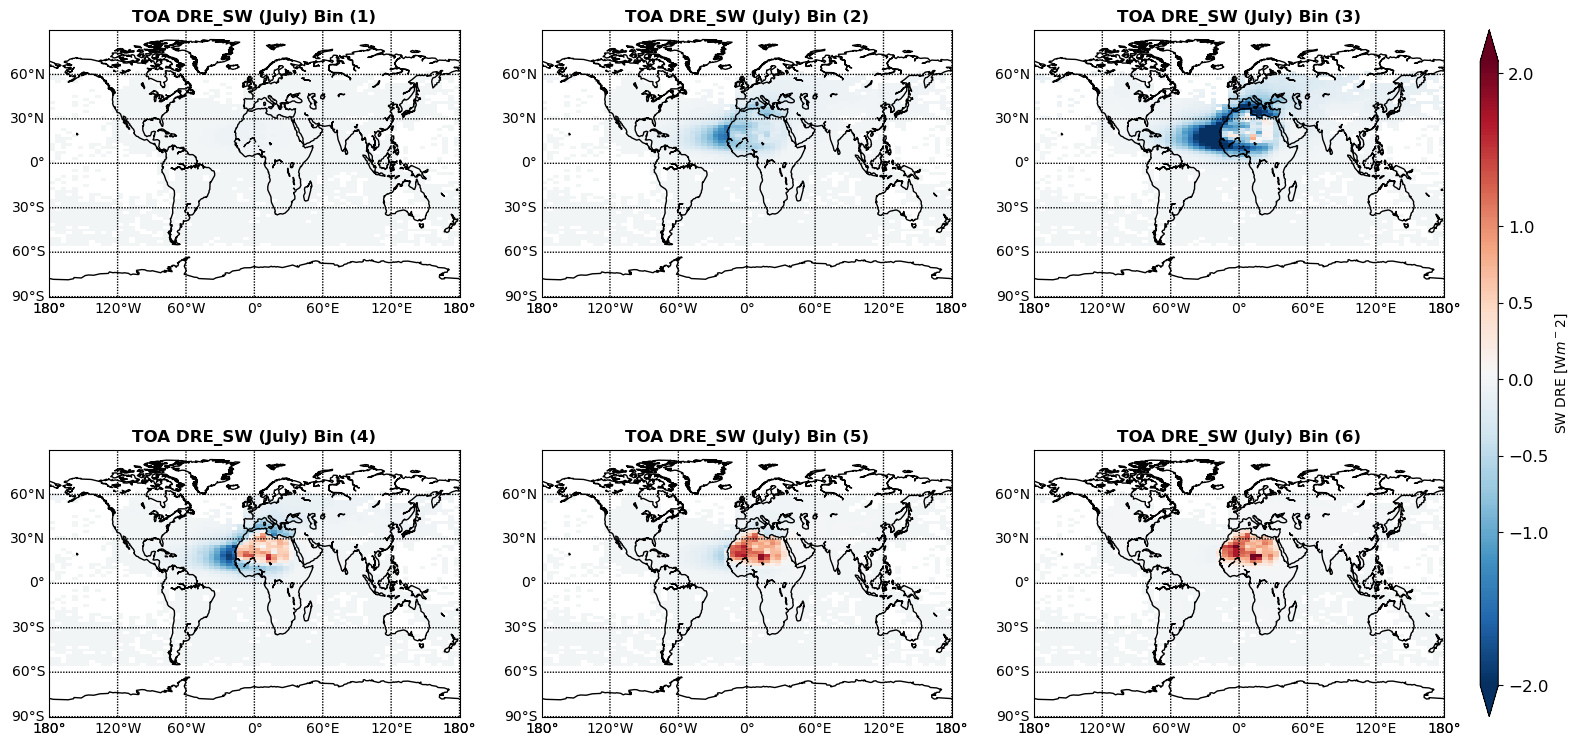

In [24]:
##Trying to learn how to plot specific months and bins ###

#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)

bounds_swdre = np.arange(-2,2.1,0.02)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)

##Sahara Only: 10W, 30E lattiutude and 15N-30N and longitude
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(2,3,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)
#map = Basemap(llcrnrlon = -30, llcrnrlat = 0, urcrnrlon = 50, urcrnrlat = 40) #for North Africa zoom

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

#Plot July DRE by bin
imn=6 # July
binn = np.arange(0,6,1)

fig_arrangement = [ax[0,0] ,ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]

for i in binn:
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,nn_dresw_meanri_sphere_toa_bin_weighted[binn[i],imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('TOA DRE_SW ({:s}) Bin ({:})'.format(mns[imn],binn[i]+1),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,2].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[1,2].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-2,-1,-.5,0,.5,1.0,2]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DRE [W$m^-2$]')
#add units to cbar W/m^2


# 8. SW DRE calculated by month, bin averaged

/var/folders/47/97wl1v310zqcw6zy080_r_8r0000gs/T/ipykernel_1010/2591478873.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  cmap.set_bad(color='grey')


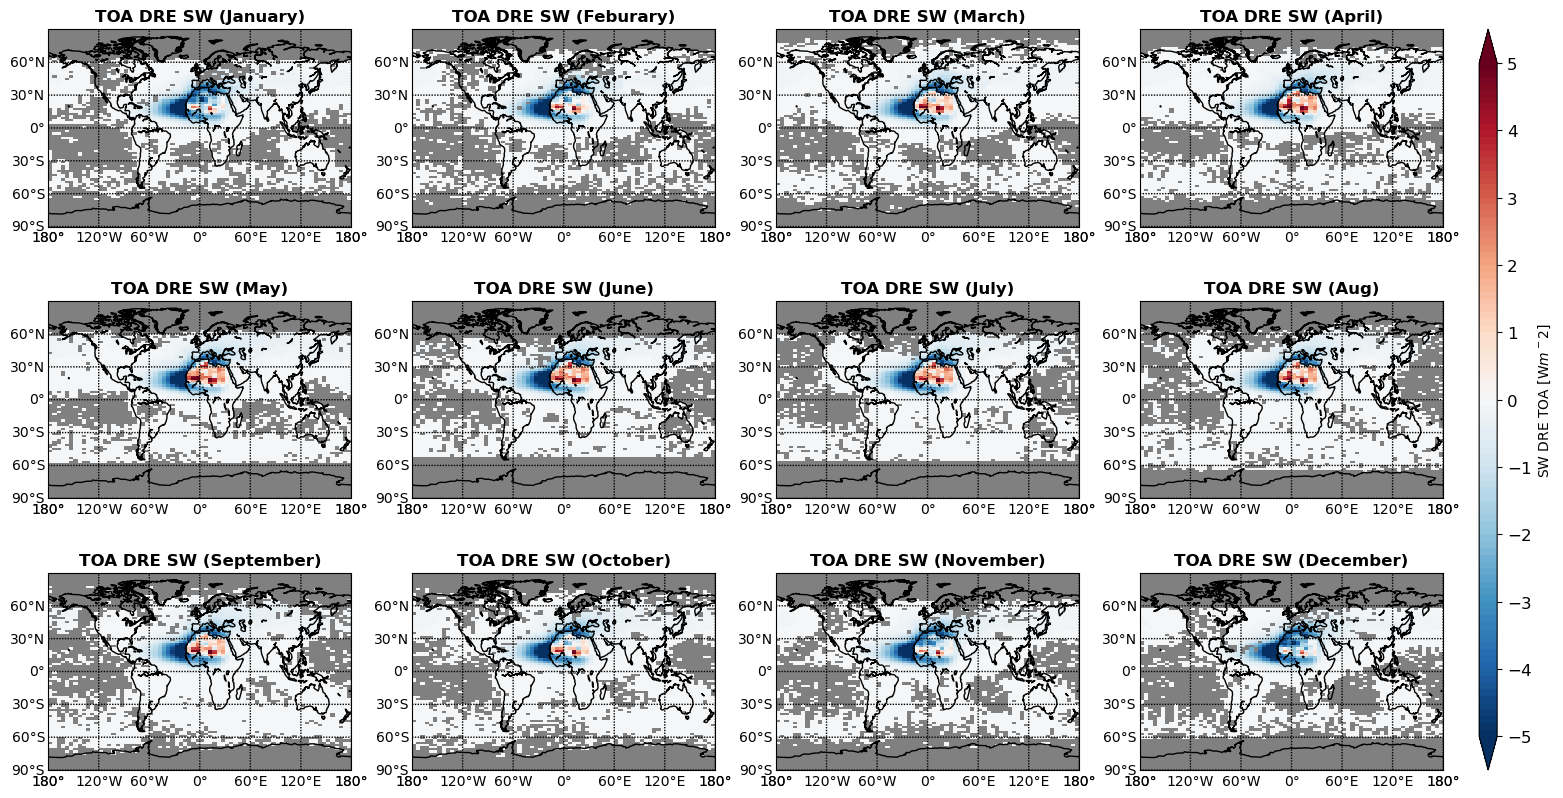

In [25]:
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-5,5.1,0.1)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
##Sahara Only: 10W, 30E lattiutude and 15N-30N and longitude
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(3,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

#Plot DRE bin averaged by month 
months = np.arange(0,12,1)
fig_arrangement = [ax[0,0] ,ax[0,1], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3], ax[2,0], ax[2,1], ax[2,2],ax[2,3]]
plt.title('North African Dust')

for i in months:
    imn=months[i]
    axis=fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('TOA DRE SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap=plt.get_cmap('RdBu_r')
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,3].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[2,3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DRE TOA [W$m^-2$]')
#add units to cbar W/m^2


# 8. a) SW DRE for bin 4 -by month

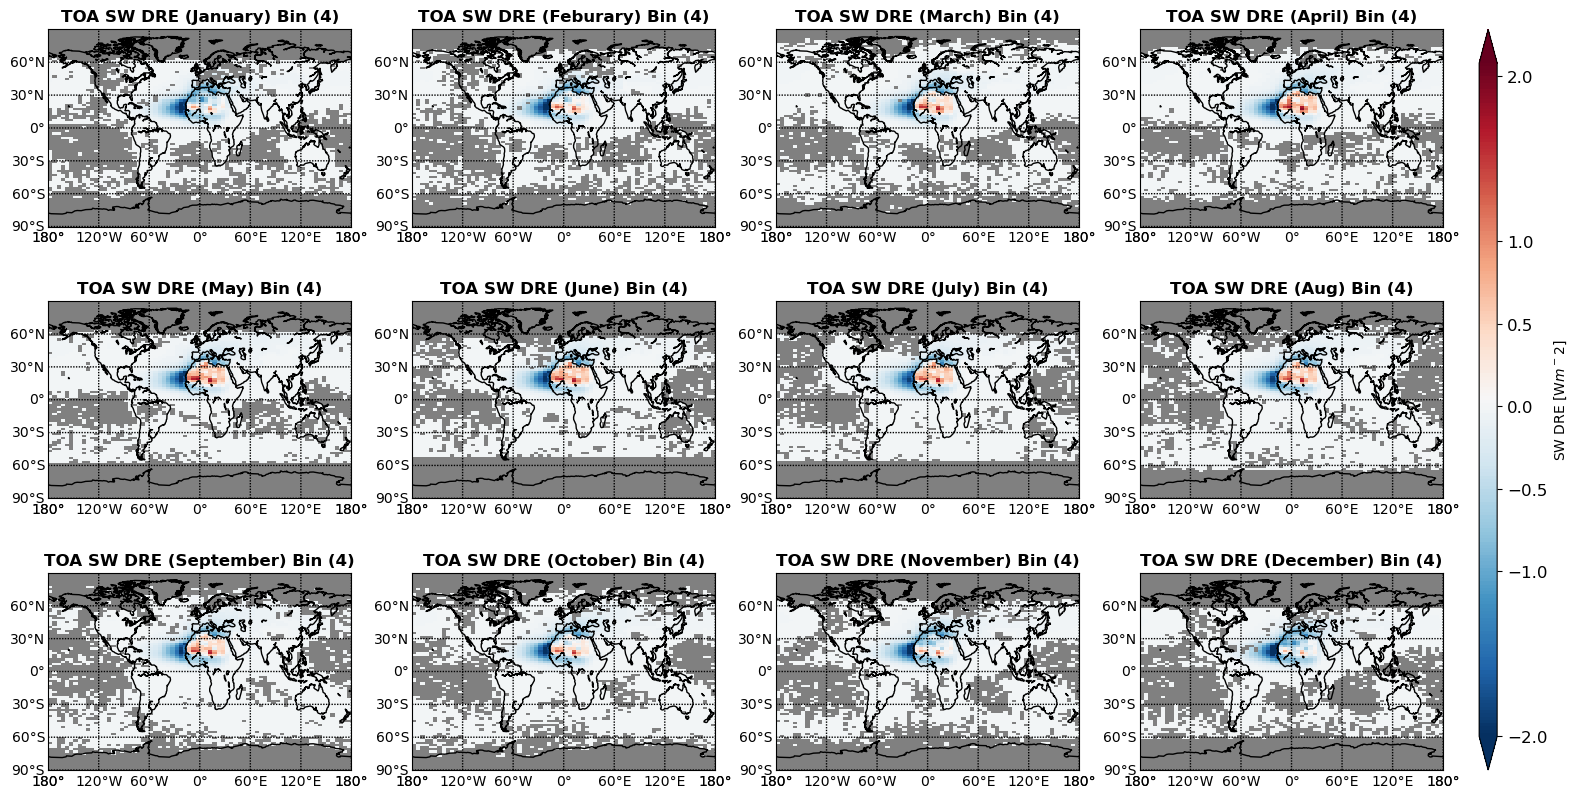

In [50]:
#bin 4 is bin[3]
binn = 3
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-2,2.1,0.02)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(3,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

#Plot DRE bin averaged by month 
months = np.arange(0,12,1)
fig_arrangement = [ax[0,0] ,ax[0,1], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3], ax[2,0], ax[2,1], ax[2,2],ax[2,3]]

months = np.arange(0,12,1)
for i in months:
    imn = months[i]
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,nn_dresw_meanri_sphere_toa_bin_weighted[binn,imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('TOA SW DRE ({:s}) Bin ({:})'.format(mns[imn],binn+1),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,3].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[2,3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-2,-1,-.5,0,.50,1,2]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DRE [W$m^-2$]')


# Calculate annual avg North African dust SW DRE TOA

In [27]:
month_sum = np.zeros((90,72))
for ilat in range(90):
    for ilon in range(72):
        month_sum[ilat,ilon] = np.nansum(bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[:,ilat,ilon])/(12)
print(np.array(month_sum).shape)
print(np.array(month_sum[0]).shape)
month_sum = np.array(month_sum)
sw_DRE_NorthAf_annual_avg = month_sum
print(sw_DRE_NorthAf_annual_avg)

(90, 72)
(72,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


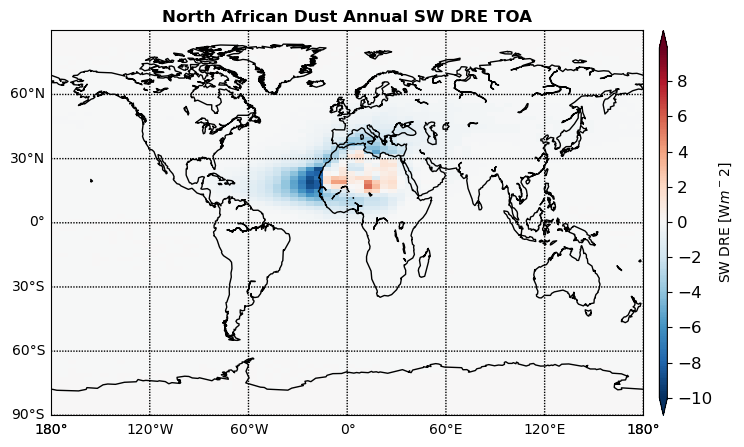

In [53]:

#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-10,10,0.1)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

#Plot DRE annual average 

fig,ax = plt.subplots(1,1,figsize=(8,5))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3

#Plot DRE bin averaged by month 
fig_arrangement = ax #[0,0]

axis= fig_arrangement
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,month_sum,cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('North African Dust Annual SW DRE TOA',fontsize=12,fontweight='bold')
axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax.get_position().get_points()
[[x10,y10],[x11,y11]] = ax.get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-10,-8,-6,-4,-2,0,2,4,6,8,10]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DRE [W$m^-2$]')


# Calculate global avg North African dust SW DRE TOA

In [29]:
np.mean(month_sum)

-0.11666782764526788

# 9. Calculate DRE SW Monthly average(across all bins)

In [30]:
bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted.shape

(12, 90, 72)

In [31]:
#AREA WEIGHTED
#----------
#For each month: calculate globally-averaged dust DRE weighted by surface area of each grid cell
#----------
#print(lon)#72
#print(lat)#90
from funct_call import deg2rad
llon,llat = np.meshgrid(lon,lat)
#print(np.shape(llat))

#12 months
dresw_toa_are_and_bin_weighted_NorthAf = np.zeros(12)
test_avg = np.zeros(12)

bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted

#NorthAf DRE SW Averaged over every bin and month
for imn in range(0,12):
    x = np.ma.MaskedArray(bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,:,:],mask=np.isnan(bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,:,:]))
    dresw_toa_are_and_bin_weighted_NorthAf[imn] = np.average(x, weights=(np.cos(deg2rad(llat))))
print(len(dresw_toa_are_and_bin_weighted_NorthAf)) 
print("Monthly DRE North African Dust Avg =",dresw_toa_are_and_bin_weighted_NorthAf)        


12
Monthly DRE North African Dust Avg = [-0.18800356 -0.16483304 -0.14684591 -0.14107125 -0.13928003 -0.13205105
 -0.1343088  -0.13752136 -0.14653938 -0.16716478 -0.19174594 -0.19941533]


# 10. b) MIN AND MAX Range of Global DRE SW bin sum  - Mean RI

# Not Area weighted but bin weighted

In [32]:
#FIND MIN AND MAX Range of DRE SW by month (summed over bins) 
#later,across first 6 bins -only up to 5 um so not including last 4 bin centers 
#so len(dreesw_meanri_sphere_bin_center)-5


#2/13/23 :includes * weights(lat) --> need to divide out or name new variable?
imn=0
maxval = 0
minval = 0
maxval_index = []
minval_index = []
for i in range(0,len(bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,imn,:])): 
    for j in range(0, len(bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,:,imn])):
            for m in range(0,12):
                if bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[m,j,i] > maxval:
                    maxval = bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[m,j,i]
                    maxval_index = [[m,j,i]]
                if bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[m,j,i] < minval:
                    minval = bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[m,j,i]
                    minval_index = [[m,j,i]]
                    
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

print("Maximum SW DRE for North African dust = "+ str(maxval) + 'in month of '+ str(mns[3]))
print("Minimum SW DRE for North African dust = "+ str(minval) + 'in month of '+ str(mns[10]))
print(maxval_index) #month3, lat53, lon38
print(minval_index) #month10, lat54, lon32 


Maximum SW DRE for North African dust = 6.99605555068041in month of April
Minimum SW DRE for North African dust = -10.146007128077853in month of November
[[3, 53, 38]]
[[10, 54, 32]]


# 10 a) MIN AND MAX Range of Global DRE SW by bin - Mean RI

In [33]:
nn_dresw_meanri_sphere_toa_bin_weighted.shape

(6, 12, 90, 72)

In [34]:
nn_dresw_meanri_sphere_toa_bin_weighted[:,0,0,0].shape

(6,)

In [35]:
#FIND MIN AND MAX Range of DRE SW -by bin and month
#later,across first 6 bins -only up to 5 um so not including last 4 bin centers 
#so len(dreesw_meanri_sphere_bin_center)-5

imn=0
binn = 0
maxval = 0
minval = 0
maxval_index = []
minval_index = []
for i in range(0,len(nn_dresw_meanri_sphere_toa_bin_weighted[binn,imn,imn,:])): 
    for j in range(0, len(nn_dresw_meanri_sphere_toa_bin_weighted[binn,imn,:,imn])):
        for k in range(0,len(nn_dresw_meanri_sphere_toa_bin_weighted[:,imn,imn,imn])):
            for m in range(0,12):
                if nn_dresw_meanri_sphere_toa_bin_weighted[k,m,j,i] > maxval:
                    maxval = nn_dresw_meanri_sphere_toa_bin_weighted[k,m,j,i]
                    maxval_index = [[k,m,j,i]]
                if nn_dresw_meanri_sphere_toa_bin_weighted[k,m,j,i] < minval:
                    minval = nn_dresw_meanri_sphere_toa_bin_weighted[k,m,j,i]
                    minval_index = [[k,m,j,i]]
                
print("Maximum SW DRE for North African dust by bin =", maxval)
print("Minimum SW DRE for North African dust by bin =", minval)
print(maxval_index) #bin5, month3, lat53, lon38
print(minval_index) #bin4, month6, lat61, lon32


Maximum SW DRE for North African dust by bin = 2.4035289277072436
Minimum SW DRE for North African dust by bin = -5.191894614855408
[[5, 5, 54, 39]]
[[2, 10, 54, 32]]


# 11. Calculate DREE and DRE for SW Sahara Mean RI by bin and month

# *12. DREE calculations

# 12. a) DREE Plots

# i) SW DREE for July by bin

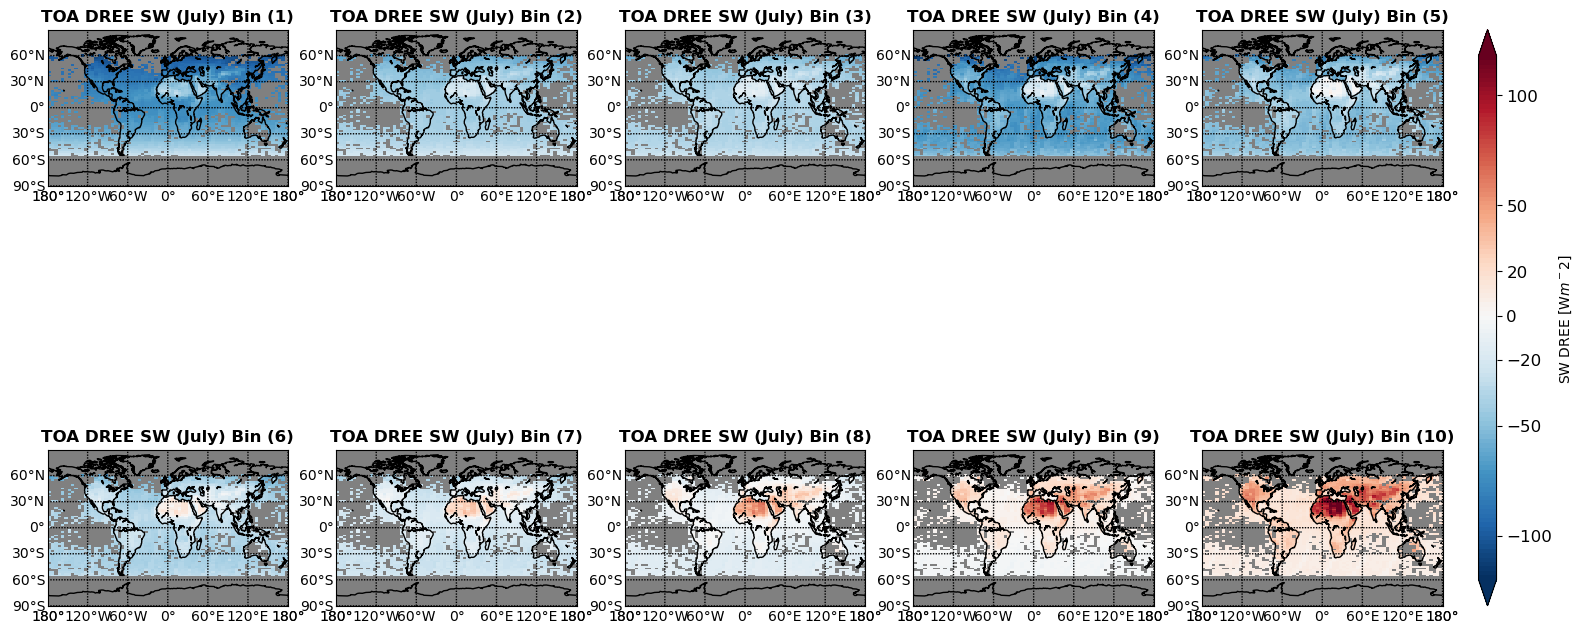

In [36]:
#dreesw_meanri_sphere_toa[:,imn,ilat,ilon]

##Trying to learn how to plot specific months and bins ###

#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)

bounds_swdree = np.arange(-120,120,2)
norm_swdree  = colors.BoundaryNorm(boundaries = bounds_swdree, ncolors = 256)

#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(2,5,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

#Plot July DRE by bin
imn=6 # July
binn = np.arange(0,10,1)

fig_arrangement = [ax[0,0] ,ax[0,1], ax[0,2], ax[0,3], ax[0,4], ax[1,0], ax[1,1], ax[1,2], ax[1,3], ax[1,4]]

for i in binn:
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,dreesw_meanri_sphere_toa[binn[i],imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdree,ax=axis)
    axis.set_title('TOA DREE SW ({:s}) Bin ({:})'.format(mns[imn],binn[i]+1),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,4].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[1,4].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-100,-50,-20,0,20,50,100]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DREE [W$m^-2$]') #DAOD is unitless so 


# ii) SW DREE for bin 4 by month

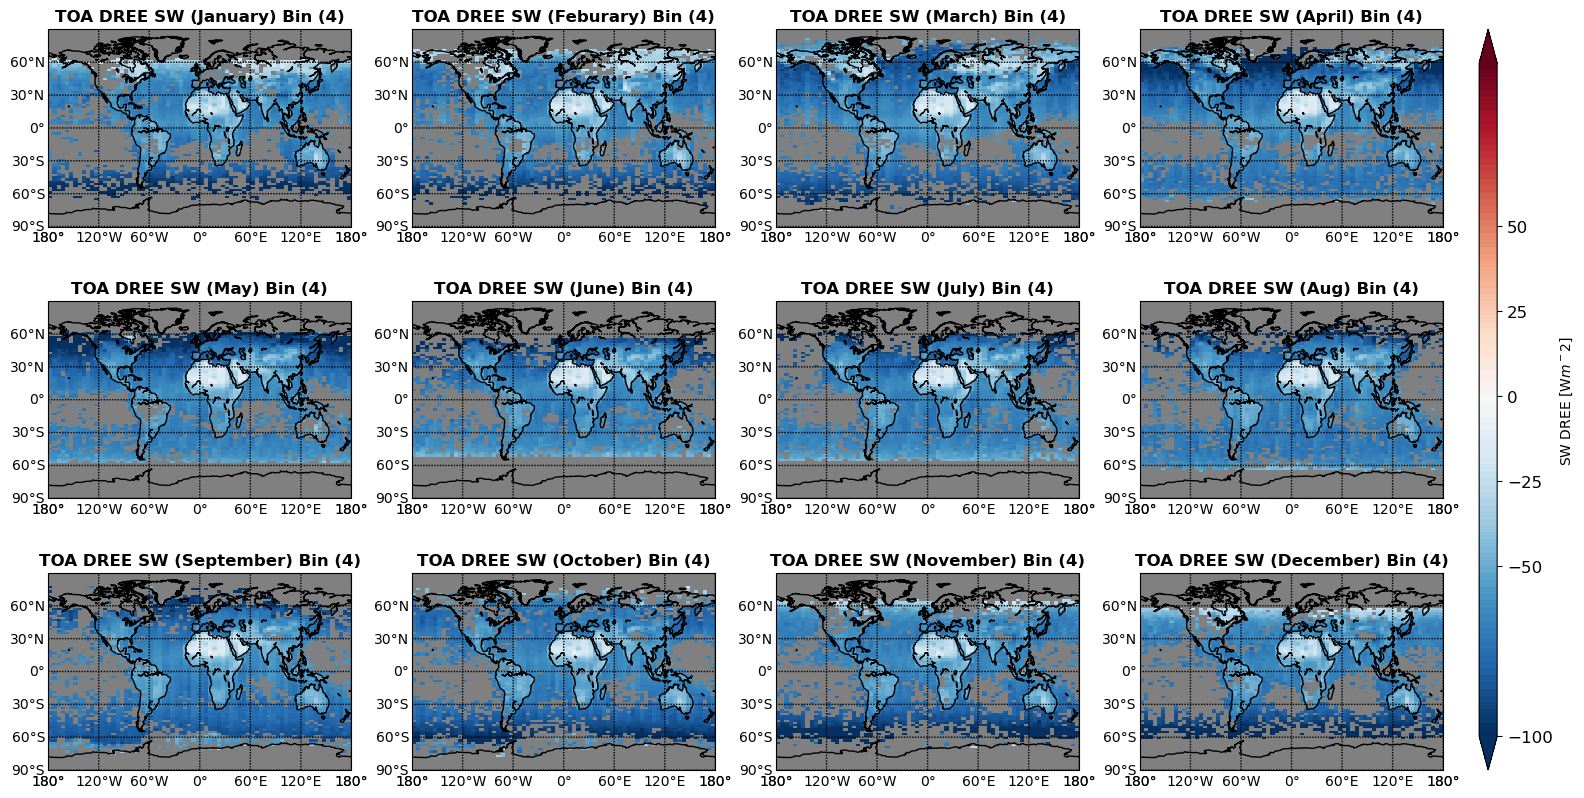

In [37]:
#bin 4 is bin[3]
binn = 3
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-100,100,2)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(3,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

#Plot DRE bin averaged by month 
months = np.arange(0,12,1)
fig_arrangement = [ax[0,0] ,ax[0,1], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3], ax[2,0], ax[2,1], ax[2,2],ax[2,3]]


months = np.arange(0,12,1)
for i in months:
    imn = months[i]
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,dreesw_meanri_sphere_toa[binn,imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('TOA DREE SW ({:s}) Bin ({:})'.format(mns[imn],binn+1),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,3].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[2,3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-100,-50,-25,0,25,50,100]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DREE [W$m^-2$]')

#expect DREE for january to be smaller than in July for N hem.


## SW DREE Bin sum Monthly plots

## 2/16 Changed np.nansum(DREE) to np.nanmean(DREE) over bins

In [38]:
dreesw_meanri_sphere_toa.shape

dreesw_bin_sum = np.zeros((12,90,72))
for ilat in range(90):
    for ilon in range(72):
        for imn in range(12):
            dreesw_bin_sum[imn,ilat,ilon] = np.nanmean(dreesw_meanri_sphere_toa[:,imn,ilat,ilon]) #np.nansum(dreesw_meanri_sphere_toa[:,imn,ilat,ilon])
print(dreesw_bin_sum.shape)

/var/folders/47/97wl1v310zqcw6zy080_r_8r0000gs/T/ipykernel_1010/2033474462.py:7: RuntimeWarning: Mean of empty slice
  dreesw_bin_sum[imn,ilat,ilon] = np.nanmean(dreesw_meanri_sphere_toa[:,imn,ilat,ilon]) #np.nansum(dreesw_meanri_sphere_toa[:,imn,ilat,ilon])


(12, 90, 72)


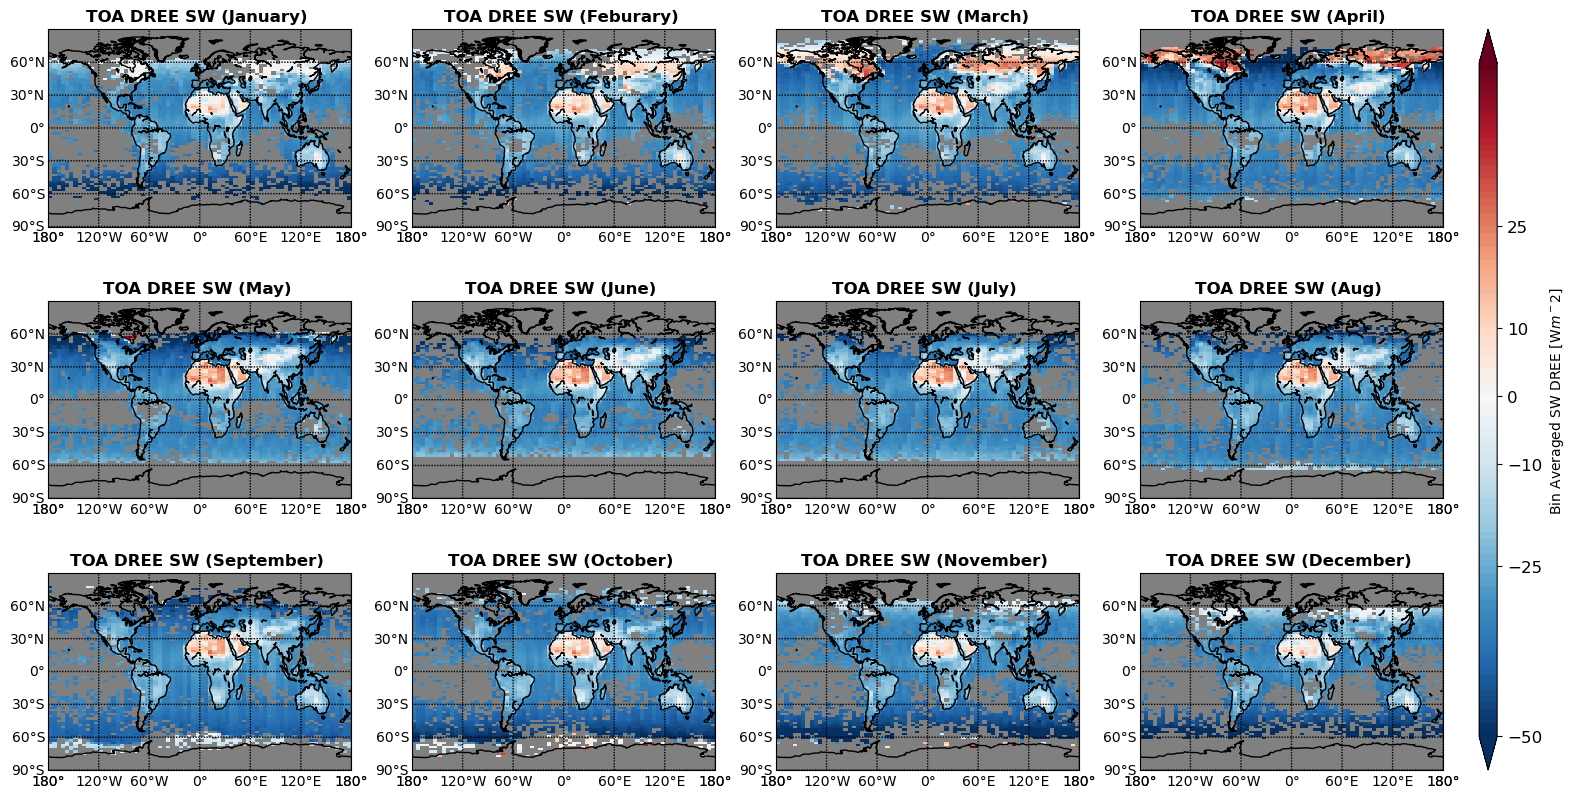

In [39]:
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


#bounds_swdre = np.arange(-350,350,10)
bounds_swdre = np.arange(-50,50,1)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(3,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

#Plot DRE bin averaged by month 
months = np.arange(0,12,1)
fig_arrangement = [ax[0,0] ,ax[0,1], ax[0,2], ax[0,3], ax[1,0], ax[1,1], ax[1,2], ax[1,3], ax[2,0], ax[2,1], ax[2,2],ax[2,3]]

for i in range(len(months)):
    imn = months[i]
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,dreesw_bin_sum[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('TOA DREE SW ({:s}) '.format(mns[imn]),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,3].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[2,3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-50,-25,-10,0,10,25,50]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('Bin Averaged SW DREE [W$m^-2$]')

#expect DREE for january to be smaller than in July for N hem.

It does appear that DREE has seasonal changes

# Saharan JJA DREE plots

## iii) sum over all DREE bins 

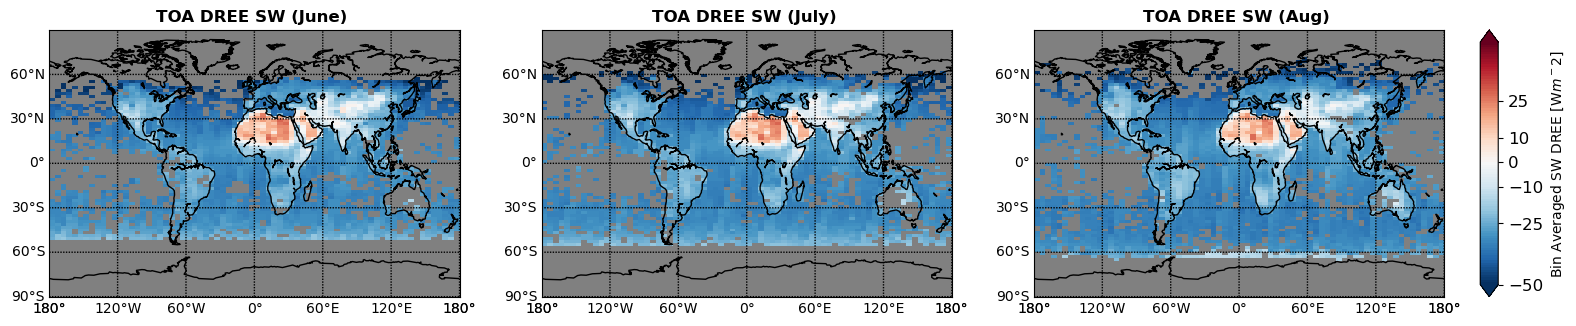

In [55]:
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)

bounds_swdre = np.arange(-50,50,1)
#bounds_swdre = np.arange(-350,350,10)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(1,3,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

#Plot DRE bin averaged by month 
months = np.arange(0,12,1)
fig_arrangement = [ax[0] ,ax[1], ax[2]]

JJA_months = np.arange(5,8,1)
for i in range(len(JJA_months)):
    imn = JJA_months[i]
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,dreesw_bin_sum[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('TOA DREE SW ({:s}) '.format(mns[imn]),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[2].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-50,-25,-10,0,10,25,50]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('Bin Averaged SW DREE [W$m^-2$]')


# 3/15 Globally Average Annual DREE for North Africa

In [79]:
print('SW DREE Not averaged annually: ',np.nanmean(dreesw_bin_sum))
#-27.690046700669306

print('dreesw_bin_sum.shape',dreesw_bin_sum.shape)

dree_Monthly_Avg = np.zeros(12)
for imn in range(12):
    dree_Monthly_Avg[imn] = np.nanmean(dreesw_bin_sum[imn,:,:])
print(dree_Monthly_Avg)
print('Mean monthly average: ',np.mean(dree_Monthly_Avg))
#-27.780721191206496

dree_annual_avg = np.zeros((90,72))
dree_annual_test = np.zeros((90,72))
for ilat in range(90):
    for ilon in range(72):
        dree_annual_avg[ilat,ilon] = np.nansum(dreesw_bin_sum[:,ilat,ilon])/12
        dree_annual_test[ilat,ilon] = np.nanmean(dreesw_bin_sum[:,ilat,ilon])
print(dree_annual_avg.shape)

SW DREE Not averaged annually:  -27.690046700669306
dreesw_bin_sum.shape (12, 90, 72)
[-27.85179224 -25.56895488 -24.03375002 -24.75681053 -29.02697013
 -27.35002909 -27.33706315 -28.16065194 -29.55642604 -29.98509078
 -30.20744871 -29.53366677]
Mean monthly average:  -27.780721191206496
(90, 72)


/var/folders/47/97wl1v310zqcw6zy080_r_8r0000gs/T/ipykernel_1010/746213370.py:18: RuntimeWarning: Mean of empty slice
  dree_annual_test[ilat,ilon] = np.nanmean(dreesw_bin_sum[:,ilat,ilon])


In [80]:
mean_Annual_DREE = np.nanmean(dree_annual_avg)
mean_test_DREE = np.nanmean(dree_annual_test)
print('mean_Annual_DREE',mean_Annual_DREE)
print('mean_test_DREE',mean_test_DREE)
#-13.926569398360032

mean_Annual_DREE -13.926569398360032
mean_test_DREE -26.45031038600647


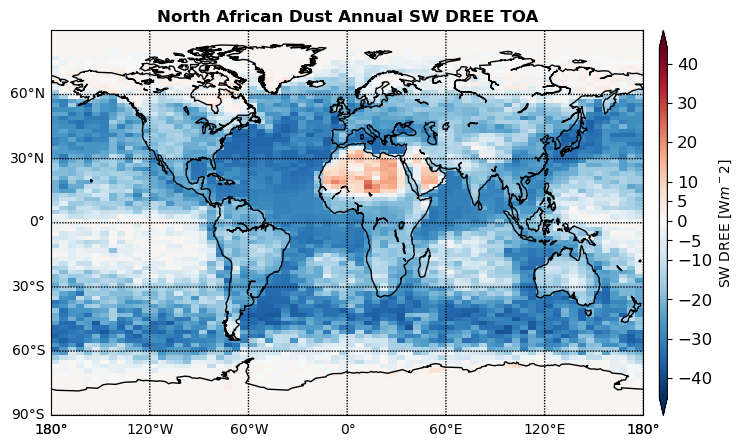

In [81]:
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-45,45,1)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DREE_SW of North African Dust
#----------

#Plot DRE annual average 

fig,ax = plt.subplots(1,1,figsize=(8,5))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3

#Plot DRE bin averaged by month 
fig_arrangement = ax #[0,0]

axis= fig_arrangement
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dree_annual_avg,cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('North African Dust Annual SW DREE TOA',fontsize=12,fontweight='bold')
axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax.get_position().get_points()
[[x10,y10],[x11,y11]] = ax.get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-40,-30,-20,-10,-5,0,5,10,20,30,40]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DREE [W$m^-2$]')

# 3/15 Global Avg Annual DAOD for North Africa

In [82]:
nn_Daod_NAf.shape

(90, 72, 6, 4)

In [83]:
bin_sum_DAOD_NAf = np.zeros((90,72,4))
seasonal_avg_DAOD = np.zeros((90,72)) 

for ilat in range(90):
    for ilon in range(72):
        for iseas in range(4):
            bin_sum_DAOD_NAf[ilat,ilon,iseas] = np.nansum(nn_Daod_NAf[ilat,ilon,:,iseas])
print(bin_sum_DAOD_NAf.shape)

for ilat in range(90):
    for ilon in range(72):
        seasonal_avg_DAOD[ilat,ilon] = np.nanmean(bin_sum_DAOD_NAf[ilat,ilon,:])
print(seasonal_avg_DAOD.shape)

(90, 72, 4)
(90, 72)


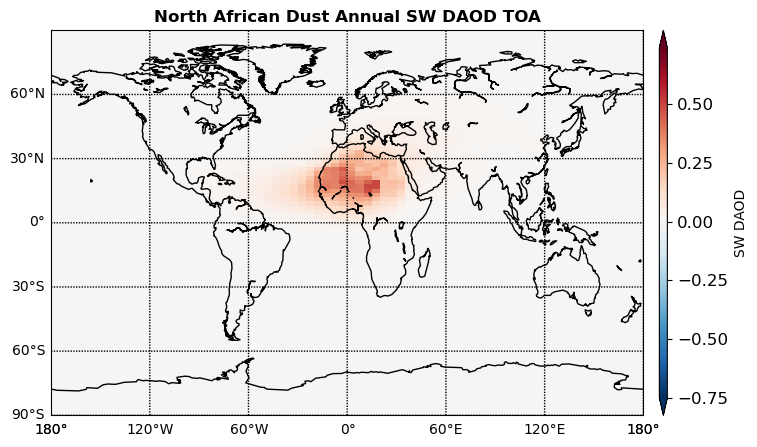

In [84]:
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-0.75,0.75,0.01)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DREE_SW of North African Dust
#----------

#Plot DRE annual average 

fig,ax = plt.subplots(1,1,figsize=(8,5))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3

#Plot DRE bin averaged by month 
fig_arrangement = ax #[0,0]

axis= fig_arrangement
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,seasonal_avg_DAOD,cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('North African Dust Annual SW DAOD TOA',fontsize=12,fontweight='bold')
axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax.get_position().get_points()
[[x10,y10],[x11,y11]] = ax.get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DAOD')

## 3/15 Global AVG DAOD

In [85]:
print('North African dust DAOD not including area weights: ',np.nanmean(seasonal_avg_DAOD))
x = np.ma.MaskedArray(seasonal_avg_DAOD,mask=np.isnan(seasonal_avg_DAOD))
dresw_DAOD_NorthAf_AVG = np.average(x, weights=(np.cos(deg2rad(llat))))
print('North African dust DAOD including area weights: ',dresw_DAOD_NorthAf_AVG)

North African dust DAOD not including area weights:  0.010392618181260312
North African dust DAOD including area weights:  0.014236026571965718


In [86]:
test_SWDRE__NAf_global_avg = dresw_DAOD_NorthAf_AVG*mean_Annual_DREE
print(test_SWDRE__NAf_global_avg)
#-0.19825901201137805
# vs. SW DRETOA Global average = -0.157 Wm-2

-0.19825901201137805


# 12. b) DREE  Sahara Average + Compare with Song et al. (2022)

In [40]:
#How do I take an average for Sahara? - limit to those (lat,lon) bounds?
#dreesw_meanri_spheroid_toa = np.array(dreesw_meanri_spheroid_data.variables['DREE_TOA'][:])
#print(dreesw_meanri_sphere_toa)
#dreesw_meanri_sphere_toa[dreesw_meanri_sphere_toa == np.nan] = 0
#np.nan_to_num(dreesw_meanri_sphere_toa)
#dreesw_meanri_sphere_toa = np.ma.MaskedArray(dreesw_meanri_sphere_toa,mask=np.isnan(dreesw_meanri_sphere_toa))
#print(dreesw_meanri_sphere_toa)
print(dreesw_meanri_sphere_toa[:].shape)

sum_SW_DREE = np.zeros((12,90,72))
for imn in range(12):
    for ilat in range(90):
        for ilon in range(72):
            sum_SW_DREE[imn,ilat,ilon] = np.nansum(dreesw_meanri_sphere_toa[:,imn,ilat,ilon])
                                           
sum_SW_DREE.shape
#print(sum_SW_DREE)
print(np.average(sum_SW_DREE))

(10, 12, 90, 72)
-139.26475873851973


# Global DREE Min and Max

In [41]:
#FIND MIN AND MAX Range of DREE SW (global)-by bin and month

imn=0
binn = 0
maxval = 0
minval = 0
maxval_index = []
minval_index = []
pre_avg =[]

for i in range(0,len(dreesw_meanri_sphere_toa[binn,imn,:,imn])): 
    for j in range(0, len(dreesw_meanri_sphere_toa[binn,imn,imn,:])):
        for k in range(0,len(dreesw_meanri_sphere_bin_center)):
            for m in range(0,12):
                if dreesw_meanri_sphere_toa[k,m,i,j] > maxval:
                    maxval = dreesw_meanri_sphere_toa[k,m,i,j]
                    maxval_index = [[k,m,i,j]]
                if dreesw_meanri_sphere_toa[k,m,i,j] < minval:
                    minval = dreesw_meanri_sphere_toa[k,m,i,j]
                    minval_index = [[k,m,i,j]]
                
print("Maximum SW DREE by bin =", maxval)
print("Minimum SW DREE by bin =", minval)
print(maxval_index)
print(minval_index)


Maximum SW DREE by bin = 313.27527
Minimum SW DREE by bin = -143.684
[[9, 10, 10, 46]]
[[3, 3, 80, 39]]


# Saharan DREE Max, Min, Avg - Trying to Replicate Song et al. 2022 value

In [42]:
#FIND MIN AND MAX Range of DREE SW for Sahara -by bin and month

dreesw_lat = np.array(dreesw_meanri_sphere_data.variables['lat'][:])
dreesw_lon = np.array(dreesw_meanri_sphere_data.variables['lon'][:])

#sahara_Lat_Mask = (dreesw_lat>15) | (dreesw_lat<30)
#sahara_Lon_Mask = (dreesw_lon>-10) | (dreesw_lon<30)
#dreesw_lat = dreesw_lat[sahara_Lat_Mask]
#dreesw_lon = dreesw_lon[sahara_Lon_Mask]
#print(dreesw_lat)
#print(dreesw_lon)

index_Sahara_lat = []
index_Sahara_lon = []
saharan_Lat = []
saharan_Lon = []
dreesw_lat_list = list(dreesw_lat)
dreesw_lon_list = list(dreesw_lon)
for i in dreesw_lat:
    if i >= 15 and i <= 30:
            index_Sahara_lat.append(dreesw_lat_list.index(i))
for j in dreesw_lon:
    if j >= -10 and j <= 30: 
            index_Sahara_lon.append(dreesw_lon_list.index(j))
print(len(index_Sahara_lat),index_Sahara_lat)
print(len(index_Sahara_lon),index_Sahara_lon)

for i in index_Sahara_lat:
    saharan_Lat.append(dreesw_lat[i])
for j in index_Sahara_lon:
    saharan_Lon.append(dreesw_lon[j])
print('saharan_Lat',saharan_Lat)
print('saharan_Lon',saharan_Lon)
                     
imn=0
binn = 0
maxval = 0
minval = 0
maxval_index = []
minval_index = []
pre_avg =[]

for i in index_Sahara_lat: 
    for j in index_Sahara_lon:
        for k in range(0,len(dreesw_meanri_sphere_bin_center)):
            for m in range(0,12):
                if dreesw_meanri_sphere_toa[k,m,j,i] > maxval:
                    maxval = dreesw_meanri_sphere_toa[k,m,j,i]
                    maxval_index = [[k,m,j,i]]
                if dreesw_meanri_sphere_toa[k,m,j,i] < minval:
                    minval = dreesw_meanri_sphere_toa[k,m,j,i]
                    minval_index = [[k,m,j,i]]
                
print("Maximum SW DREE for Sahara by bin =", maxval)
print("Minimum SW DREE for Sahara by bin =", minval)
print(maxval_index)
print(minval_index)


8 [52, 53, 54, 55, 56, 57, 58, 59]
8 [34, 35, 36, 37, 38, 39, 40, 41]
saharan_Lat [15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0]
saharan_Lon [-7.5, -2.5, 2.5, 7.5, 12.5, 17.5, 22.5, 27.5]
Maximum SW DREE for Sahara by bin = 39.05991
Minimum SW DREE for Sahara by bin = -84.56261
[[9, 11, 34, 59]]
[[3, 10, 38, 55]]


# Calculate Sahara Mean RI DREE SW JJA TOA to compare to Song et al. 2022

# 2/2 add area weight

In [43]:
llon,llat = np.meshgrid(lon,lat)
#print(np.shape(llat))

In [44]:
dreesw_meanri_sphere_toa.shape
all_sum_dree = np.zeros((12,90,72))
#maybe add up sum over l0 bins for DREE and then do area weight
for i in range(0,90):
    for j in range(0,72):
        for imn in range(0,12):
            all_sum_dree[imn,i,j] = np.nansum(dreesw_meanri_sphere_toa[:,imn,i,j])
print(all_sum_dree.shape)
#print(all_sum_dree)

(12, 90, 72)


In [45]:
print("Not area weighted global mean DREE = ",np.nanmean(dreesw_meanri_sphere_toa))

Not area weighted global mean DREE =  -27.690357


In [46]:
np.cos(deg2rad(llat)).shape

(90, 72)

## 2/16 North African global DREE -area weighted + original 10 bins

In [47]:
#NorthAf DREE SW Averaged over every bin and month
dreesw_toa_are_and_bin_weighted_NorthAf = np.zeros((10,12))
for imn in range(0,12):
    x = np.ma.MaskedArray(dreesw_meanri_sphere_toa[:,imn,:,:],mask=np.isnan(dreesw_meanri_sphere_toa[:,imn,:,:]))
    #print(x.shape)
    for i in range(len(x[:,0,0])):
        dreesw_toa_are_and_bin_weighted_NorthAf[i,imn] = np.average(x[i], weights=np.cos(deg2rad(llat)))
print(len(dreesw_toa_are_and_bin_weighted_NorthAf)) 
print("Area weighted global mean DREE = ",np.mean(dreesw_toa_are_and_bin_weighted_NorthAf))
print("Monthly DREE North African Dust Avg",dreesw_toa_are_and_bin_weighted_NorthAf)        

10
Area weighted global mean DREE =  -17.43018697698911
Monthly DREE North African Dust Avg [[-36.12700653 -38.77291489 -43.30421829 -46.48908615 -45.6498642
  -39.36242676 -40.81268692 -42.96843338 -45.30496597 -45.77987671
  -41.72378922 -35.32183075]
 [-22.03368378 -23.47706413 -26.39220238 -28.24843979 -27.42685318
  -23.57154846 -24.49160194 -25.75788689 -27.1978569  -27.60423088
  -25.27199173 -21.58010101]
 [-19.95200729 -21.17922211 -23.95314026 -25.56228065 -24.51709557
  -20.87648964 -21.7339325  -22.91454697 -24.27565193 -24.76376534
  -22.77918625 -19.57184982]
 [-35.73601532 -38.06459427 -43.28217316 -46.04398346 -43.75934219
  -36.73736954 -38.27368164 -40.57640839 -43.32290268 -44.32804489
  -40.79073715 -35.04493332]
 [-26.43847275 -28.03448677 -31.85237122 -33.80850601 -32.14332581
  -26.75006676 -27.89539337 -29.67699051 -31.84383774 -32.71390152
  -30.19676018 -25.97838593]
 [-18.60392189 -19.35371017 -21.6035347  -22.89093018 -22.2231102
  -18.45126534 -19.32471085 

## 2/7 Global DREE Monthly Average - summing over all bins in DREE

In [48]:
sum_SW_DREE = np.zeros(12) #np.zeros((3,8,8))
JJA = [5,6,7]
for imn in range(0,12):
    #for ilat in index_Sahara_lat:
        #for ilon in index_Sahara_lon:
            #x = np.average(dreesw_meanri_sphere_toa[:,imn,ilat,ilon])
            #sum_SW_DREE_sahar.append(x) 
    x = np.ma.MaskedArray(all_sum_dree[imn,:,:],mask=np.isnan(all_sum_dree[imn,:,:]))
    sum_SW_DREE[imn] = (np.average(x)) #, weights=np.cos(deg2rad(llat))))     

print(len(sum_SW_DREE))
print(sum_SW_DREE)
#print(np.mean(sum_SW_DREE_sahar))

#weight in the area of each grid box
#Jupyter lab
#write up methods

12
[-123.31295049 -127.52910822 -140.96787672 -146.51600063 -150.15185777
 -119.74079092 -127.69952185 -142.45465579 -157.90459001 -163.06706778
 -147.72747689 -124.1052078 ]


## 2/7 Saharan DREE Monthly Average

In [49]:
print(len(index_Sahara_lat))
print("index_Sahara_lat: ",index_Sahara_lat)
print(len(index_Sahara_lon))
print("index_Sahara_lon: ",index_Sahara_lon)
print(all_sum_dree.shape)
print(llat.shape)

8
index_Sahara_lat:  [52, 53, 54, 55, 56, 57, 58, 59]
8
index_Sahara_lon:  [34, 35, 36, 37, 38, 39, 40, 41]
(12, 90, 72)
(90, 72)


## 2/16 Saharan JJA DREE area weighted vs Song et al. 2022 Saharan JJA DREE

In [50]:
sahara_lat = []
sahara_lon = []
for i in index_Sahara_lat:
    sahara_lat.append(dreesw_lat[i])
for j in index_Sahara_lon:
    sahara_lon.append(dreesw_lon[j])
shr_lon,shr_lat = np.meshgrid(sahara_lon,sahara_lat)
#print(shr_lon)
#print(shr_lat)

In [51]:
saharan_JJA_SW_DREE = np.zeros((10,3,8,8)) 
JJA = [5,6,7]

for ilat in index_Sahara_lat:
        for ilon in index_Sahara_lon:
            for imn in JJA:
                saharan_JJA_SW_DREE[:,imn-5,ilat-52,ilon-34] = dreesw_meanri_sphere_toa[:,imn,ilat,ilon] 
                
print(saharan_JJA_SW_DREE.shape)         

(10, 3, 8, 8)


# 2-16 Still getting ~15 including area weights

In [52]:
saharan_JJA_monthly_DREE = np.zeros((10,3))
JJA = [5,6,7]
for imn in range(len(JJA)):
        y = np.average(saharan_JJA_SW_DREE[:,:,:,:])
        x = np.ma.MaskedArray(saharan_JJA_SW_DREE[:,imn,:,:],mask=np.isnan(saharan_JJA_SW_DREE[:,imn,:,:]))
        #print(x[0].shape)
        #print(x.shape)
        for i in range(len(x[:,0,0])):
            saharan_JJA_monthly_DREE[i,imn] = np.average(x[i], weights=np.cos(deg2rad(shr_lat)))
        #saharan_JJA_monthly_DREE[imn] = (np.average(x)) #, weights=np.cos(deg2rad(shr_lat)))) 
print("not area-weighted avg JJA Saharan DREE",y)
print(len(saharan_JJA_monthly_DREE))
#print(saharan_JJA_monthly_DREE)
print("area-weighted avg JJA Saharan DREE",np.mean(saharan_JJA_monthly_DREE))

not area-weighted avg JJA Saharan DREE 15.178148864096148
10
area-weighted avg JJA Saharan DREE 15.139695722819361


Song et al. 2022 SW DREE Sahara for JJA for Mean RI, TOA is 16 so 15.2 is close

# *13. DAOD Plots

# 2/7 North African DAOD 

In [53]:
print(nn_Daod_NAf.shape)
print(len(dreesw_lat_list))

(90, 72, 6, 4)
90


In [54]:
#FIND MIN AND MAX Range of SW DAOD

dreesw_lat = np.array(dreesw_meanri_sphere_data.variables['lat'][:])
dreesw_lon = np.array(dreesw_meanri_sphere_data.variables['lon'][:])

index_Sahara_lat = []
index_Sahara_lon = []
dreesw_lat_list = list(dreesw_lat)
dreesw_lon_list = list(dreesw_lon)
for i in dreesw_lat:
    if i >= 15 and i <= 30:
            index_Sahara_lat.append(dreesw_lat_list.index(i))          
for j in dreesw_lon:
    if j >= -10 and j <= 30:
            index_Sahara_lon.append(dreesw_lon_list.index(j))
print(len(index_Sahara_lat),index_Sahara_lat)
print(len(index_Sahara_lon),index_Sahara_lon)
                     
maxval = 0
minval = 0
maxval_index = []
minval_index = []
pre_avg =[]

for i in index_Sahara_lat: 
    for j in index_Sahara_lon:
        for ibin in range(6):
            for iseas in range(4):
                if nn_Daod_NAf[i,j,ibin,iseas] > maxval:
                    maxval = nn_Daod_NAf[i,j,ibin,iseas]
                    maxval_index = [[i,j,ibin,iseas]]
                if nn_Daod_NAf[i,j,ibin,iseas] < minval:
                    minval = nn_Daod_NAf[i,j,ibin,iseas]
                    minval_index = [[i,j,ibin,iseas]]
                
print("Maximum SW DAOD for Sahara by bin =", maxval)
print("Minimum SW DAOD for Sahara by bin =", minval)
print(maxval_index)
print(minval_index)


8 [52, 53, 54, 55, 56, 57, 58, 59]
8 [34, 35, 36, 37, 38, 39, 40, 41]
Maximum SW DAOD for Sahara by bin = 0.27093512826267807
Minimum SW DAOD for Sahara by bin = 0
[[52, 38, 2, 1]]
[]


In [55]:
print(dustcomm_seas) 
#1:DJF, 2:MAM, 3:JJA, 4:SON

[1. 2. 3. 4.]


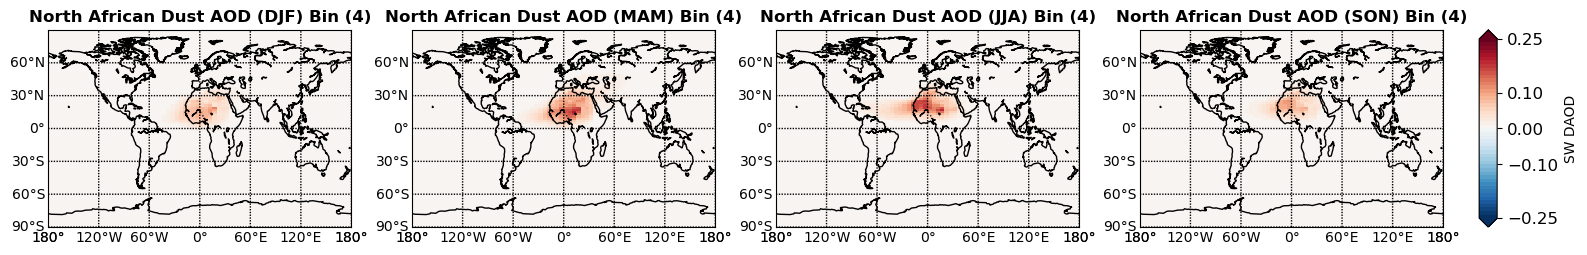

In [56]:
#bin 4 is bin[3]
binn = 3
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-0.25,0.251,0.01)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(1,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
seas=np.array(['DJF','MAM','JJA','SON'])

#Plot DRE bin averaged by month 
months = np.arange(0,12,1)
fig_arrangement = [ax[0] ,ax[1], ax[2], ax[3]]

months = np.arange(0,12,1)
for i in range(4):
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,nn_Daod_NAf[:,:,binn,i],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('North African Dust AOD ({:s}) Bin ({:})'.format(seas[i],binn+1),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-0.25,-0.1,0,0.1,0.25]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DAOD')

## 2/7 DAOD sum over bins

In [57]:
nn_Daod_NAf.shape

(90, 72, 6, 4)

In [58]:
NAf_daod_bin_sum = np.zeros((90,72,4))
for ilat in range(90):
    for ilon in range(72):
        for iseas in range(4):
            NAf_daod_bin_sum[ilat,ilon,iseas] = np.sum(nn_Daod_NAf[ilat,ilon,:,iseas])
print(NAf_daod_bin_sum.shape)


(90, 72, 4)


## 2/7 DAOD Bin sum plots

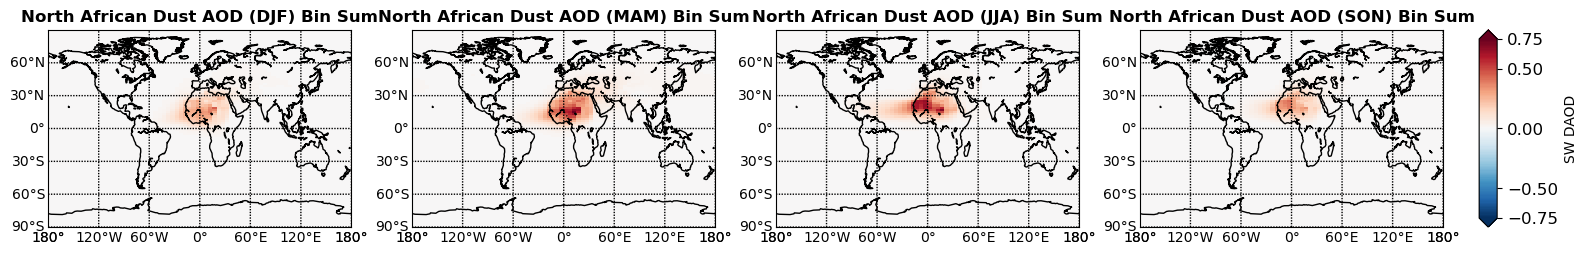

In [59]:
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)


bounds_swdre = np.arange(-0.75,0.751,0.01)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)
#----------
#Global Map of Monthly Mean DRE_SW of North African Dust
#----------

fig,ax = plt.subplots(1,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)

Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
seas=np.array(['DJF','MAM','JJA','SON'])

#Plot DRE bin averaged by month 
months = np.arange(0,12,1)
fig_arrangement = [ax[0] ,ax[1], ax[2], ax[3]]

months = np.arange(0,12,1)
for i in range(4):
    axis= fig_arrangement[i]
    map.drawcoastlines(ax=axis)
    map.drawparallels(np.arange(-90.,90.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
    cs00=map.pcolormesh(Lon,Lat,NAf_daod_bin_sum[:,:,i],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
    axis.set_title('North African Dust AOD ({:s}) Bin Sum'.format(seas[i]),fontsize=12,fontweight='bold')
    axis.set_aspect(aspect)
    
cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-0.75,-0.5,0,0.5,0.75]))
axcb.ax.tick_params(labelsize=12)
axcb.set_label('SW DAOD')

In [60]:
#bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted[imn,ilat,ilon] = np.sum(dreesw_meanri_sphere_toa_6bins[:,imn,ilat,ilon]*nn_Daod_NAf[ilat,ilon,:,2]*faod_mean_sphere_6bins)

In [61]:
print(len(index_Sahara_lat),index_Sahara_lat)
print(len(index_Sahara_lon),index_Sahara_lon)
print(NAf_daod_bin_sum.shape)
print(all_sum_dree.shape)
print(dreesw_bin_sum.shape)
print(bin_sum_nn_dresw_meanri_sphere_toa_bin_weighted.shape)
#nn_Daod_NAf[i,j,ibin,iseas]

8 [52, 53, 54, 55, 56, 57, 58, 59]
8 [34, 35, 36, 37, 38, 39, 40, 41]
(90, 72, 4)
(12, 90, 72)
(12, 90, 72)
(12, 90, 72)


# 2-15 Testing with one (lat,lon) point in Sahara, 1 month, all 6 bins

In [62]:
july = 6
test_lat = 52
test_lon = 34
JJA = 2
dre_test = dreesw_meanri_sphere_toa_6bins[:,july,test_lat,test_lon]* nn_Daod_NAf[test_lat,test_lon,:,JJA]*faod_mean_sphere_6bins
print('dre_test', dre_test)
print('test DAOD',nn_Daod_NAf[test_lat,test_lon,:,JJA])
dree_test = dre_test/(nn_Daod_NAf[test_lat,test_lon,:,JJA]*faod_mean_sphere_6bins)
print('dree_test',dree_test)
print('fk', faod_mean_sphere_6bins)
#print('dreesw_meanri_sphere_toa_6bins[:,july,test_lat,test_lon]',dreesw_meanri_sphere_toa_6bins[:,july,test_lat,test_lon])

dre_test [-0.00682349 -0.22777553 -0.81699094 -0.13209043  0.04359647  0.00721193]
test DAOD [0.00404674 0.03316658 0.13791266 0.09368562 0.05485293 0.02649289]
dree_test [-15.21875572 -32.73413849 -17.87559891  -5.8093648    8.42829609
  24.97442436]
fk [0.11079548 0.2098     0.3314     0.2427     0.0943     0.0109    ]


In [63]:
dreesw_meanri_sphere_toa_6bins[:,july,test_lat,test_lon]

array([-15.21875572, -32.73413849, -17.87559891,  -5.8093648 ,
         8.42829609,  24.97442436])

In [64]:
np.mean(dreesw_meanri_sphere_toa_6bins[:,july,test_lat,test_lon])

-6.372522910435994

## 2/16 Original 10 bin DREE

In [76]:
dreesw_meanri_sphere_toa[:,july,test_lat,test_lon]

array([-53.72786 , -29.672419, -22.686268, -32.73414 , -17.875599,
        -5.809365,   8.428296,  24.974424,  42.53248 ,  61.69918 ],
      dtype=float32)

In [77]:
np.mean(dreesw_meanri_sphere_toa[:,july,test_lat,test_lon])

-2.487126